In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf
import pmdarima as pm


In [3]:
all_stocks = pd.read_csv('stock_yfinance_data.csv')
print(all_stocks.shape)
all_stocks.head()

(6300, 8)


,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name
0,2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,TSLA
1,2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,TSLA
2,2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,TSLA
3,2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,TSLA
4,2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,TSLA


In [4]:
stock_df = all_stocks[all_stocks['Stock Name'] == "TSLA"]
stock_df['Date'] = pd.to_datetime(stock_df['Date'])
stock_df['Date'] = stock_df['Date'].dt.date

/var/folders/pk/797syh6d4477zd69bq0trp140000gn/T/ipykernel_75863/3636239815.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Date'] = pd.to_datetime(stock_df['Date'])
/var/folders/pk/797syh6d4477zd69bq0trp140000gn/T/ipykernel_75863/3636239815.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Date'] = stock_df['Date'].dt.date


In [5]:
stock_df

,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name
0,2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,TSLA
1,2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,TSLA
2,2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,TSLA
3,2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,TSLA
4,2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,TSLA
...,...,...,...,...,...,...,...,...
247,2022-09-23,283.089996,284.500000,272.820007,275.329987,275.329987,63748400,TSLA
248,2022-09-26,271.829987,284.089996,270.309998,276.010010,276.010010,58076900,TSLA
249,2022-09-27,283.839996,288.670013,277.510010,282.940002,282.940002,61925200,TSLA
250,2022-09-28,283.079987,289.000000,277.570007,287.809998,287.809998,54664800,TSLA


In [6]:
finance_df = stock_df[['Date', 'Close']]

### Basic autocorrelation testing

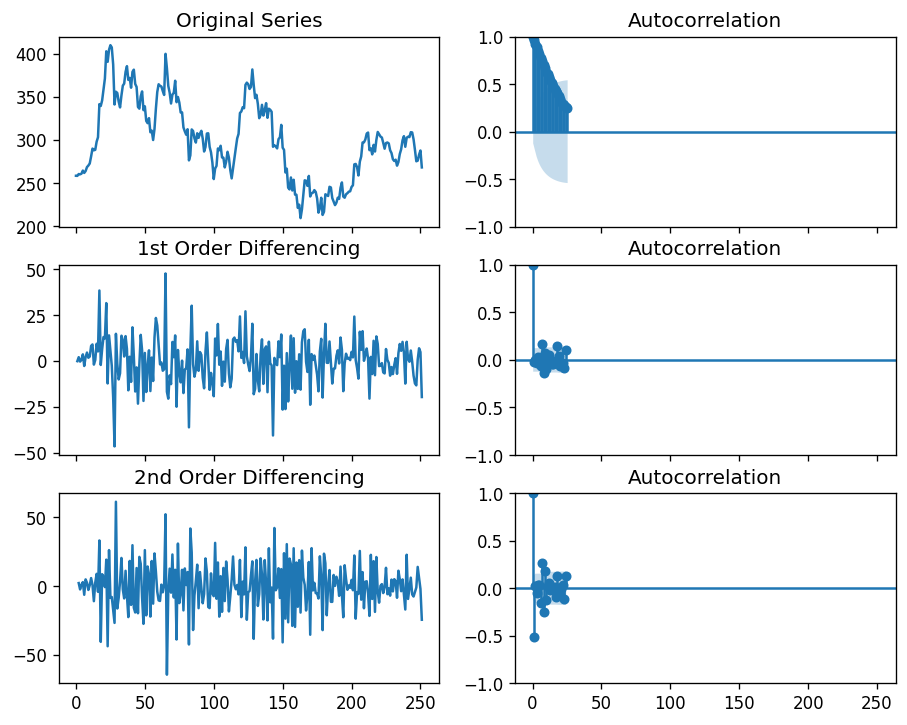

In [7]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(finance_df.Close); axes[0, 0].set_title('Original Series')
plot_acf(finance_df.Close, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(finance_df.Close.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(finance_df.Close.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(finance_df.Close.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(finance_df.Close.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

### auto ARIMA

In [8]:
data = pd.read_csv('stock_yfinance_data.csv', parse_dates=['Date'], index_col='Date')

In [9]:
data = data[data['Stock Name'] == "TSLA"]
data = data.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume', 'Stock Name'])

In [10]:
# Create Training and Test
train = data[:-50]
test = data[-50:]

In [159]:
# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(train, start_p=1, start_q=1,
                         test='adf',
                         max_p=20, max_q=20, m=11,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True, # d=0: let model decide
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[11] intercept   : AIC=inf, Time=0.91 sec
 ARIMA(0,0,0)(0,1,0)[11] intercept   : AIC=1987.595, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[11] intercept   : AIC=1615.824, Time=0.17 sec
 ARIMA(0,0,1)(0,1,1)[11] intercept   : AIC=1804.111, Time=0.23 sec
 ARIMA(0,0,0)(0,1,0)[11]             : AIC=1985.778, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[11] intercept   : AIC=1660.238, Time=0.03 sec
 ARIMA(1,0,0)(2,1,0)[11] intercept   : AIC=1592.095, Time=0.77 sec
 ARIMA(1,0,0)(2,1,1)[11] intercept   : AIC=inf, Time=1.00 sec
 ARIMA(1,0,0)(1,1,1)[11] intercept   : AIC=inf, Time=0.75 sec
 ARIMA(0,0,0)(2,1,0)[11] intercept   : AIC=1988.152, Time=0.61 sec
 ARIMA(2,0,0)(2,1,0)[11] intercept   : AIC=1593.033, Time=1.03 sec
 ARIMA(1,0,1)(2,1,0)[11] intercept   : AIC=1593.050, Time=0.86 sec
 ARIMA(0,0,1)(2,1,0)[11] intercept   : AIC=1806.919, Time=0.88 sec
 ARIMA(2,0,1)(2,1,0)[11] intercept   : AIC=1595.026, Time=1.20 sec
 ARIMA(1,0,0)(2,1,0)[11]          

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  202
Model:             SARIMAX(1, 0, 0)x(2, 1, [1], 11)   Log Likelihood                -773.747
Date:                              Fri, 26 Apr 2024   AIC                           1557.493
Time:                                      23:34:51   BIC                           1573.754
Sample:                                           0   HQIC                          1564.080
                                              - 202                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9760      0.020     49.904      0.000       0.938       1.014
ar.S.L11      -0.0607      0.090     -0.676      0.499      -0.237       0.115
ar.S.L22      -0.1092      0.102     -1.073      0.283      -0.309       0.090
ma.S.L11      -0.8911      0.113     -7.875      0.000      -1.113      -0.669
sigma2       173.1729     15.216     11.381      0.000     143.349     202.996
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):                18.32
Prob(Q):                              0.73   Prob(JB):                         0.00
Heteroskedasticity (H):               0.67   Skew:                             0.06
Prob(H) (two-sided):                  0.11   Kurtosis:                         4.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


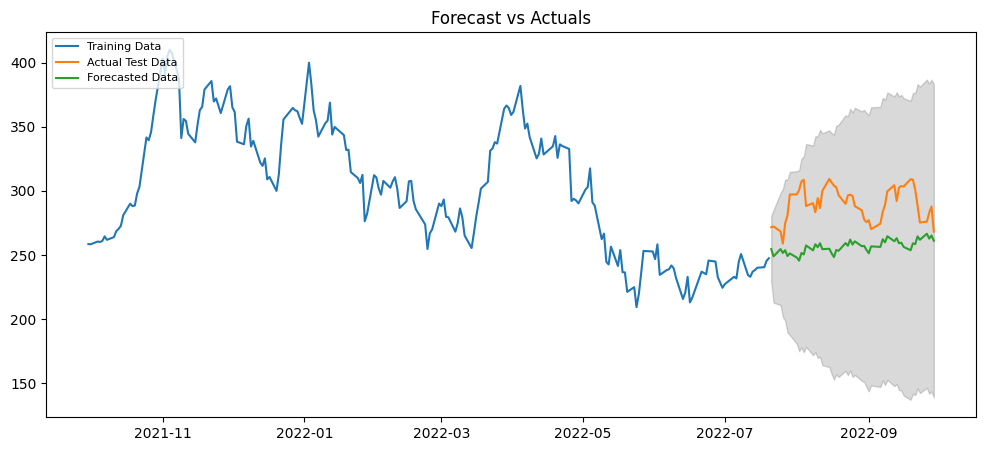

In [160]:
# Forecasting the next 50 data points
forecast_result = smodel.predict(n_periods=50, return_conf_int=True)
fc_series = pd.Series(np.array(forecast_result[0]), index=test.index)
conf_int = forecast_result[1]

# Extracting confidence intervals
lower_series = pd.Series(conf_int[:, 0], index=test.index)
upper_series = pd.Series(conf_int[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train['Close'], label='Training Data')
plt.plot(test['Close'], label='Actual Test Data')
plt.plot(fc_series, label='Forecasted Data')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

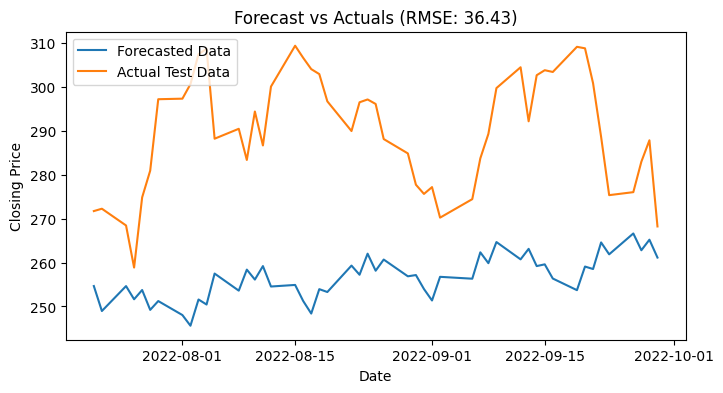

In [161]:
from sklearn.metrics import mean_squared_error
import math

# Calculate RMSE
rmse = math.sqrt(mean_squared_error(test['Close'], fc_series))

# Plot RMSE
plt.figure(figsize=(8, 4), dpi=100)
plt.plot(fc_series, label='Forecasted Data')
plt.plot(test['Close'], label='Actual Test Data')
plt.title(f'Forecast vs Actuals (RMSE: {rmse:.2f})')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend(loc='upper left')
plt.show()

In [162]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score

# Calculate MAE
mae = mean_absolute_error(test['Close'], fc_series)

# Calculate MAPE
mape = mean_absolute_percentage_error(test['Close'], fc_series)

# Calculate R2 score
r2 = r2_score(test['Close'], fc_series)

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R2 Score: {r2:.2f}")

MAE: 33.48
MAPE: 0.11%
R2 Score: -6.85
